<a href="https://colab.research.google.com/github/Ashish-Tripathy/ComputerVision/blob/master/Asg10_ClassActivationMaps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Libraries and modules**

In [0]:
import numpy as np
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Add, BatchNormalization
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
import matplotlib.pyplot as plt
% matplotlib inline
from keras.datasets import mnist
from google.colab.patches import cv2_imshow

Using TensorFlow backend.


# Loading a Pretrained VGG Model

Let's start with a pretrained VGG model

In [0]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
import numpy as np
import cv2
from skimage import io
model = VGG16(weights="imagenet")

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

# GradCAM

## Defining functions for implementation

In [0]:
def test_img_predict(img):
  preds = model.predict(img)
  class_idx = np.argmax(preds)
  print("Class_ID: ", class_idx)
  class_output = model.output[:, class_idx]
  return class_output

To check the map for the top prediction, we take the topmost class index.

### Selecting the output from the final convolution layer and computing gradient with class output

In [0]:
def gradient_FeatureHeatMap(last_conv_name, class_output, channel_num,img_pr):
  last_conv_layer = model.get_layer(last_conv_name)
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([img_pr])
  for i in range(channel_num):
      conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  return heatmap

We compute the gradient of the class output value with respect to the feature map. Then, we pool the gradients over all the axes leaving out the channel dimension. Finally, we weigh the output feature map with the computed gradient values. We also evaluate the heatmap by averaging the weighed feature map

### Defining the function to plot Gradient weighted Class Activation Map (GradCAM)

In [0]:
def plot_gradCAM(heatmap, img):  
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = cv2.addWeighted(img, 0.5, heatmap, 0.5, 0)
  from google.colab.patches import cv2_imshow
  cv2_imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  cv2_imshow(superimposed_img)
  return superimposed_img

Adds the heatmap with the image with more weights to image. A superimposed image is obtained which has brighter pixels where the activation happens

## Plotting GradCAM for any image

I took an image of my microwave and uploaded it to check if the trained vgg can guess the correct class Geyser:)

Class_ID:  886


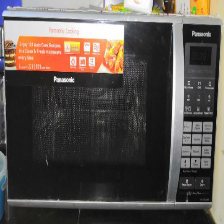

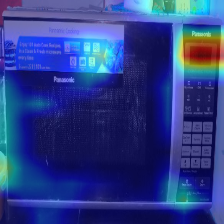

In [0]:
mypic = io.imread("https://i.imgur.com/S5TG2u3.jpg")
img = cv2.resize(mypic, dsize=(224, 224))#, interpolation=cv2.INTER_CUBIC)
x = image.img_to_array(img)
x = np.expand_dims(img, axis=0)
x = preprocess_input(x)
class_output = test_img_predict(x)
heatmap = gradient_FeatureHeatMap("block5_conv3",class_output, 512,x)
superimposed = plot_gradCAM(heatmap, img)


It predicted as class 886: 'vending machine'  instead of microwave. Close though but not exactly the class i was looking for.:)

## Plotting from layer above this layer

Class_ID:  886


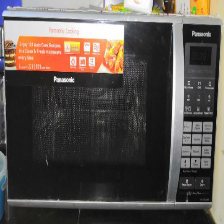

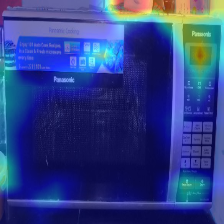

In [0]:
mypic = io.imread("https://i.imgur.com/S5TG2u3.jpg")
img = cv2.resize(mypic, dsize=(224, 224))#, interpolation=cv2.INTER_CUBIC)
x = image.img_to_array(img)
x = np.expand_dims(img, axis=0)
x = preprocess_input(x)
class_output = test_img_predict(x)
heatmap = gradient_FeatureHeatMap("block5_conv2",class_output, 512,x)
superimposed = plot_gradCAM(heatmap, img)

## Plotting from layer above the previous layer

Class_ID:  886


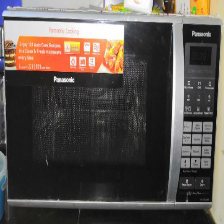

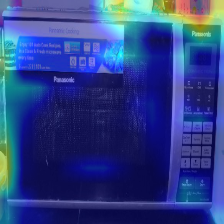

In [0]:
mypic = io.imread("https://i.imgur.com/S5TG2u3.jpg")
img = cv2.resize(mypic, dsize=(224, 224))#, interpolation=cv2.INTER_CUBIC)
x = image.img_to_array(img)
x = np.expand_dims(img, axis=0)
x = preprocess_input(x)
class_output = test_img_predict(x)
heatmap = gradient_FeatureHeatMap("block5_conv1",class_output, 512,x)
superimposed = plot_gradCAM(heatmap, img)

Interestingly the previous layers were focussig from the noise from other things in the kitchen and last layer atleast then started focussing on the digital display tab.

## Plotting GradCAM for the Angry IronMan's Sunglasses

In [0]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Class_ID:  836


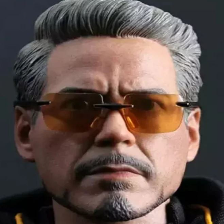

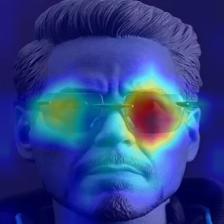

In [0]:
mypic = io.imread("/content/drive/My Drive/AngryIronMan.JPG")
img = cv2.resize(mypic, dsize=(224, 224))#, interpolation=cv2.INTER_CUBIC)
x = image.img_to_array(img)
x = np.expand_dims(img, axis=0)
x = preprocess_input(x)
class_output = test_img_predict(x)
heatmap = gradient_FeatureHeatMap("block5_conv3",class_output, 512,x)
superimposed = plot_gradCAM(heatmap, img)

<b>Class  836: 'sunglass' perfectly identified by the network. The activations make it pretty clear the network clearly is able to distinguish sunglasses in the face.